**WORKFLOW STAGES**



1.   Question or problem definition.
2.   Project Aim/Goal.
3.   Wrangle, prepare, cleanse the data.
4.   Analyze, identify patterns, and explore the data.
5.   Model, predict and solve the problem. 



**Question and problem definition**

**Context**

“Getting the perfect music recommendation is a challenging task. Who has never dreamt of laying back and listening to some music, while having no buttons to press at all and still getting the perfect tune? But what defines this perfect tune?

Deezer is a music streaming app, also available on the web. It proposes more than 43 million tracks and is available in more than 180 countries, through a free limited service and a premium offer.

For this online challenge, Deezer wants you to look at Flow, its own music recommendation radio. The concept of Flow is simple: it uses collaborative filtering to provide a user with the music he wants to listen at the time he wants.... And if he does not want to listen to some specific tracks and skips songs by pressing the 'Next song' button, then the algorithm should detect it quickly. In this context, getting the first song recommendation right is really important“ ([Kaggle, 2017, parag. 1](https://www.kaggle.com/competitions/dsg17-online-phase/overview)).




**Project Aim/Goal**


The goal of this challenge is to predict whether the users of the test dataset listened to the first track Flow proposed them or not. Deezer considers that a track is "listened" if the user has listened to more than 30 seconds of it (is_listened =1). If the user presses the skip button to change the song before 30 seconds, then the track is not considered as being listened (is_listened = 0).

The test dataset consists in a list of the first recommended tracks on Flow for several users. Each row represents one user.

The train dataset was generated using the listening history of these Deezer users for one month. Each row represents one listened track. The list of distinct users in the train dataset matches exactly with the test dataset's one."

At the end we try to answer the following 3 questions:

- What would we do to win this competition?
- What would we do to solve the problem that Deezer is interested in?
- Why might the two solutions not overlap or why they do?

In [87]:
# Load Python libraries

import matplotlib as mpl
import warnings
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


**Acquire data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

**Train & Test Data Exploration**

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:

train_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_music.csv")
test_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_music.csv")


The datasets contain the following features (variable is_listened is only present in the train dataset as it is the variable you need to predict)([Kaggle, 2017](https://www.kaggle.com/competitions/dsg17-online-phase/overview)):

Data fields:
- media_id - identifiant of the song listened by the user
- album_id - identifiant of the album of the song
- media_duration - duration of the song
- user_gender -  gender of the user
- user_id -  anonymized id of the user
- context_type - type of content where the song was listened: playlist, album ...
- release_date - release date of the song with the format YYYYMMDD
- ts_listen - timestamp of the listening in UNIX time
- platform_name - type of os
- platform_family - type of device
- user_age - age of the user
- listen_type - if the songs was listened in a flow or not
- artist_id - identifiant of the artist of the song
- genre_id - identifiant of the genre of the song
- is_listened - 1 if the track was listened, 0 otherwise


In [90]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517484 entries, 0 to 517483
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   genre_id         517484 non-null  int64  
 1   ts_listen        517484 non-null  int64  
 2   media_id         517484 non-null  int64  
 3   album_id         517484 non-null  int64  
 4   context_type     517484 non-null  int64  
 5   release_date     517484 non-null  int64  
 6   platform_name    517483 non-null  float64
 7   platform_family  517483 non-null  float64
 8   media_duration   517483 non-null  float64
 9   listen_type      517483 non-null  float64
 10  user_gender      517483 non-null  float64
 11  user_id          517483 non-null  float64
 12  artist_id        517483 non-null  float64
 13  user_age         517483 non-null  float64
 14  is_listened      517483 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 59.2 MB
_______________________________________

In [91]:
train_df.apply(lambda x: sum(x.isnull()), axis=0)

genre_id           0
ts_listen          0
media_id           0
album_id           0
context_type       0
release_date       0
platform_name      1
platform_family    1
media_duration     1
listen_type        1
user_gender        1
user_id            1
artist_id          1
user_age           1
is_listened        1
dtype: int64

In [92]:
# drop NAs
train_df=train_df.dropna()

In [93]:
for col in ['release_date','genre_id','media_id','album_id','context_type','platform_name','platform_family','listen_type','user_gender',
                  'user_id','artist_id','is_listened']:
    train_df[col] = train_df[col].astype('category')

In [94]:
from datetime import datetime as dt 
#train_df["ts_listen"] = pd.to_datetime(train_df["ts_listen"], errors='coerce')
#train_df["release_date"] = pd.to_datetime(train_df["release_date"], errors='coerce')
#train_df["ts_listen"] = train_df["ts_listen"].dt.strftime('%Y-%m-%d')
#train_df["release_date"] = train_df["release_date"].dt.strftime('%Y-%m-%d')

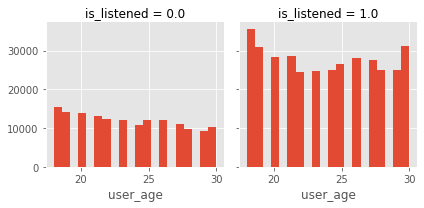

In [95]:
g = sns.FacetGrid(train_df, col='is_listened')
g.map(plt.hist, 'user_age', bins=20)

    user_age  Count
0       18.0  50858
1       19.0  45187
2       20.0  42174
3       21.0  41800
12      30.0  41387
8       26.0  40396
7       25.0  38591
9       27.0  38497
4       22.0  36823
5       23.0  36769
6       24.0  35681
10      28.0  34921
11      29.0  34399


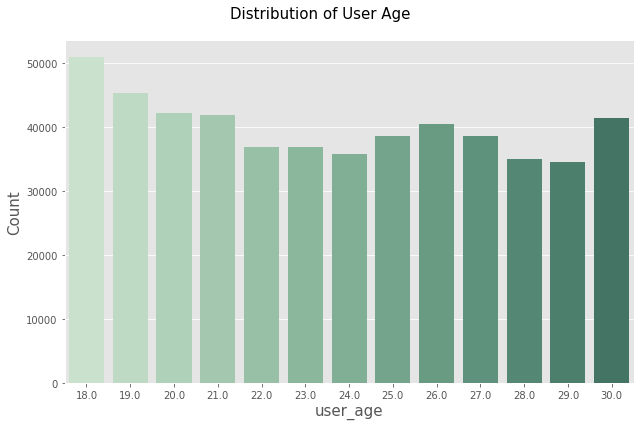

In [96]:
a = train_df.groupby('user_age').size()
a = pd.DataFrame(a)
a.reset_index(level=0, inplace=True)
a.columns = ['user_age', 'Count']
a = a.sort_values(by='Count', ascending=False)
print(a)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='user_age', y='Count', kind='bar',
                 data=a, height=6, palette='ch:2.5,-.2,dark=.4', aspect=1.5)
ax.fig.suptitle('Distribution of User Age', fontsize=15)
ax.fig.subplots_adjust(top=.9)
plt.show()

  user_gender   Count
0         0.0  323485
1         1.0  193998


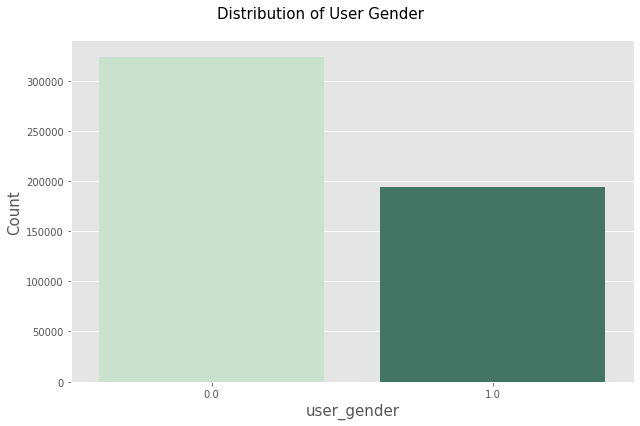

In [97]:
b = train_df.groupby('user_gender').size()
b = pd.DataFrame(b)
b.reset_index(level=0, inplace=True)
b.columns = ['user_gender', 'Count']
b = b.sort_values(by='Count', ascending=False)
print(b)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='user_gender', y='Count', kind='bar',
                 data=b, height=6, palette='ch:2.5,-.2,dark=.4', aspect=1.5)
ax.fig.suptitle('Distribution of User Gender', fontsize=15)
ax.fig.subplots_adjust(top=.9)
plt.show()

***Distribution of song length***

count    517483.000000
mean          3.882799
std           0.987091
min           0.000000
25%           3.300000
50%           3.783333
75%           4.250000
max          75.300000
Name: media_duration, dtype: float64


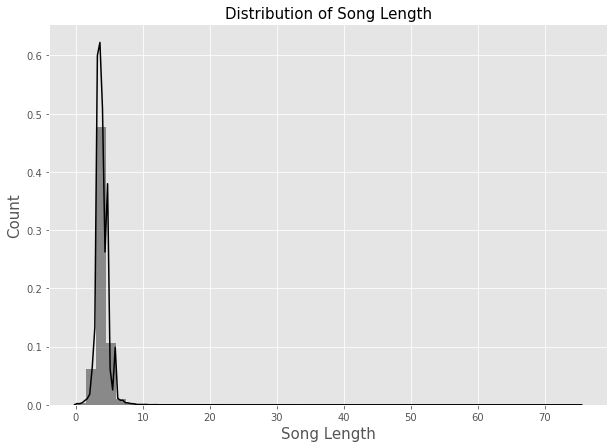

In [98]:
print((train_df.media_duration/60).describe())
plt.subplots(figsize=(10, 7))
x = train_df.media_duration/60
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()

We can see that most of the songs are below 10 min.

In [99]:
test_df.apply(lambda x: sum(x.isnull()), axis=0)

sample_id          0
genre_id           0
ts_listen          0
media_id           0
album_id           0
context_type       0
release_date       0
platform_name      0
platform_family    0
media_duration     0
listen_type        0
user_gender        0
user_id            0
artist_id          0
user_age           0
dtype: int64

In [100]:
for col in ['release_date','genre_id','media_id','album_id','context_type','platform_name','platform_family','listen_type','user_gender',
                  'user_id','artist_id']:
    test_df[col] = test_df[col].astype('category')

In [101]:
# drop NAs
test_df=train_df.dropna()

In [102]:
from datetime import datetime as dt 

from datetime import datetime as dt 
#test_df["ts_listen"] = pd.to_datetime(test_df["ts_listen"], errors='coerce')
#test_df["release_date"] = pd.to_datetime(test_df["release_date"], errors='coerce')
#test_df["ts_listen"] = test_df["ts_listen"].dt.strftime('%Y-%m-%d')
#test_df["release_date"] = test_df["release_date"].dt.strftime('%Y-%m-%d')



In [103]:
test_df

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1.0,0.0,223.0,0.0,0.0,9241.0,55164.0,29.0,0.0
1,25571,1480544735,250467,43941,0,20060301,2.0,1.0,171.0,0.0,0.0,16547.0,55830.0,30.0,1.0
2,16,1479563953,305197,48078,1,20140714,2.0,1.0,149.0,1.0,1.0,7665.0,2704.0,29.0,1.0
3,7,1480152098,900502,71521,0,20001030,0.0,0.0,240.0,0.0,1.0,1580.0,938.0,30.0,0.0
4,7,1478368974,542335,71718,0,20080215,0.0,0.0,150.0,0.0,1.0,1812.0,2939.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517478,253,1478208332,69141278,6775637,0,20130719,0.0,0.0,234.0,0.0,1.0,7.0,1000956.0,25.0,0.0
517479,253,1476822962,69141278,6775637,0,20130719,0.0,0.0,234.0,0.0,1.0,7.0,1000956.0,25.0,0.0
517480,253,1477464601,69141278,6775637,0,20130719,0.0,0.0,234.0,0.0,1.0,7.0,1000956.0,25.0,1.0
517481,253,1477658416,69141278,6775637,0,20130719,0.0,0.0,234.0,0.0,1.0,7.0,1000956.0,25.0,0.0


**Model & Prediction**

Now we are ready to train a model and predict the required solution. There are many predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Is listened or not) with other variables or features ('ts_listen', 'media_id', 'album_id', 'context_type', 'release_date'...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Naive Bayes classifier
- Stochastic Gradient Descent
- Decision Tree
- Random Forrest
- Linear Support Vector Classifier

In [109]:
X_train = train_df.drop("is_listened", axis=1)
Y_train = train_df["is_listened"]
X_test  = test_df.drop("user_id",axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape


((517483, 14), (517483,), (517483, 14))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function.

In [110]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

69.74

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [111]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,context_type,6.056559e-07
5,platform_name,1.359089e-07
12,user_age,4.790632e-09
8,listen_type,7.194553e-11
4,release_date,1.262470e-11
13,is_listened,1.089043e-11
6,platform_family,5.749262e-12
7,media_duration,4.224130e-12
10,user_id,-1.295351e-12
9,user_gender,-2.769690e-12


We selected the most informative columns using Random Forest Model.

In [112]:
# Model with the best estimator
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
model =RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(train_df[train_df.columns[train_df.columns != 'is_listened']], train_df.is_listened)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [113]:
train_df_plot = pd.DataFrame({'features': train_df.columns[train_df.columns != 'is_listened'],
                        'importances': model.feature_importances_})
train_df_plot = train_df_plot.sort_values('importances', ascending=False)

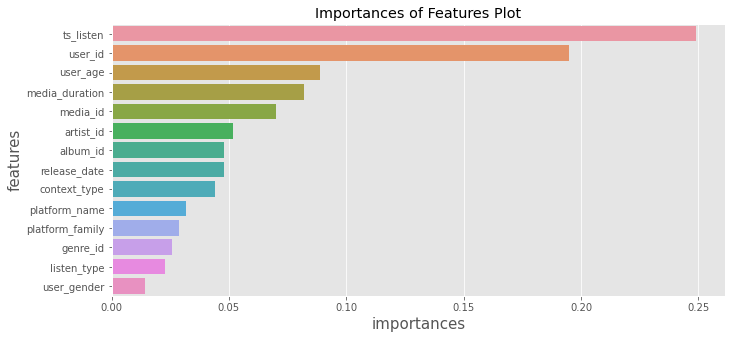

In [114]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [115]:
# Drop columns with importances < 0.04
train_df = train_df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)
#df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [116]:
# Selected columns
train_df.columns

Index(['ts_listen', 'media_id', 'album_id', 'context_type', 'release_date',
       'media_duration', 'user_id', 'artist_id', 'user_age', 'is_listened'],
      dtype='object')

In [117]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(X_train, Y_train)
Y_pred = logreg_model.predict(X_test)
acc_log = round(logreg_model.score(X_train, Y_train) * 100, 2)
acc_log



69.74

In [118]:
# KNeighbors

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, Y_train)
Y_pred = knn_model.predict(X_test)
acc_knn = round(knn_model.score(X_train, Y_train) * 100, 2)
acc_knn


82.33

In [119]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

69.74

In [120]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

99.63

In [121]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

99.63

In [122]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

30.28

In [123]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

69.74

**Model evaluation**

We can now rank our evaluation of all the models to choose the best one for our problem. 

In [126]:
models = pd.DataFrame({
    'Model': [ 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,99.63
6,Decision Tree,99.63
0,KNN,82.33
1,Logistic Regression,69.74
4,Stochastic Gradient Decent,69.74
5,Linear SVC,69.74
3,Naive Bayes,30.28


While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.


In [127]:
test_df_final = pd.DataFrame({
        "user_id": test_df["user_id"],
        "is_listened": Y_pred
    })

In [129]:
test_df_final.tail()

,user_id,is_listened
517478,7.0,1.0
517479,7.0,1.0
517480,7.0,1.0
517481,7.0,1.0
517482,7.0,1.0
